### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import math
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set Seed

In [2]:
# Random seed for reproducibility
seed = 26

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Variable Definition

In [3]:
input_dir = "../input"
dataset_dir = os.path.join(input_dir, 'dataset')
column_names = ['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness', 'Hype root']

window = 200
stride = 10
telescope = 48

### Exploring Data Analysis (EDA)

#### Load the dataset

In [4]:
dataset = pd.read_csv(os.path.join(dataset_dir, 'Training.csv'))
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


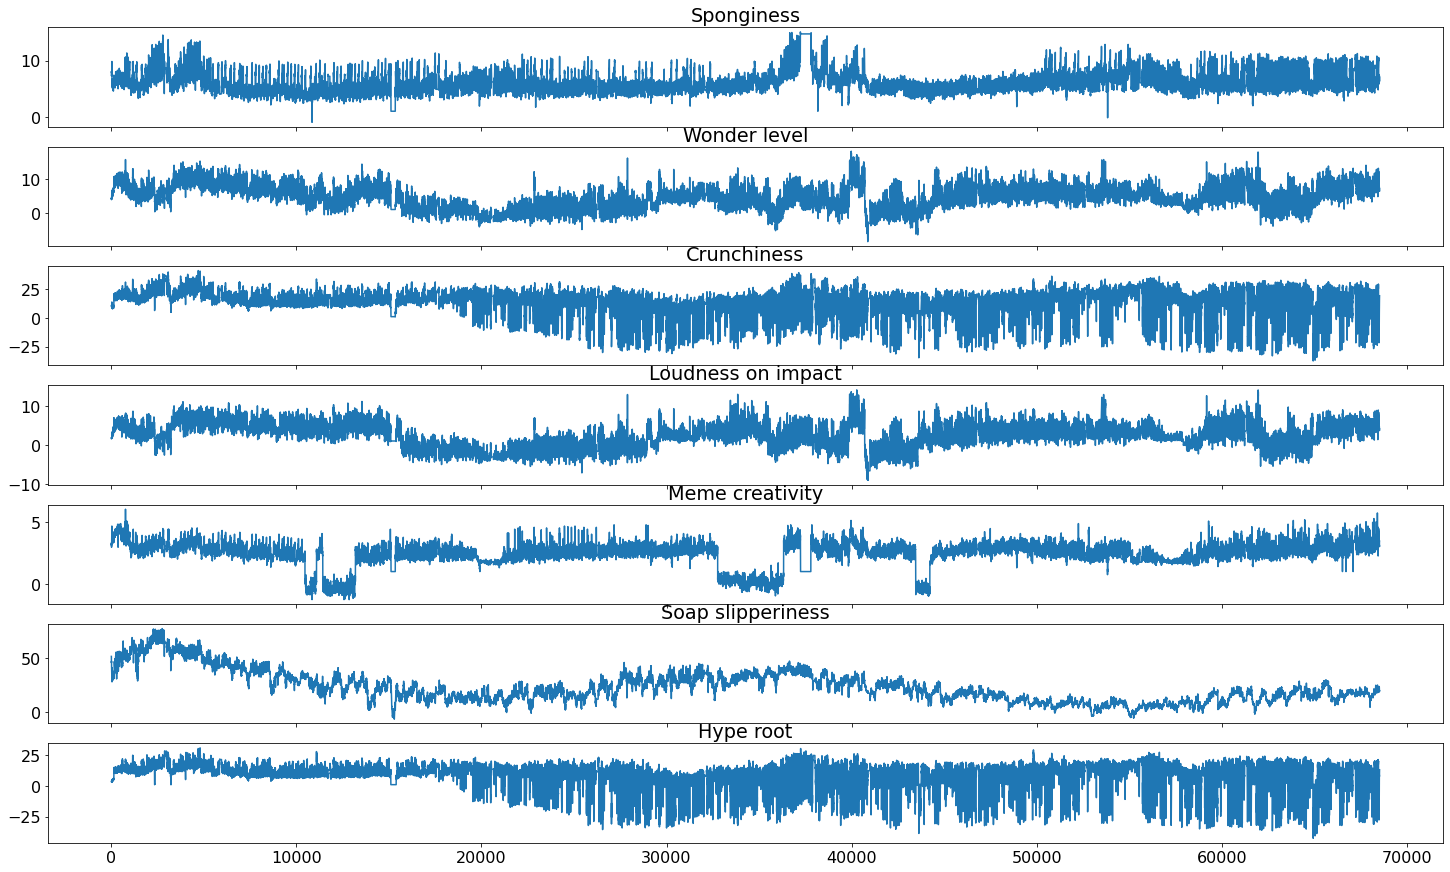

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,15))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, column_names)

#### Train and Validation split

(61676, 7) (6852, 7)


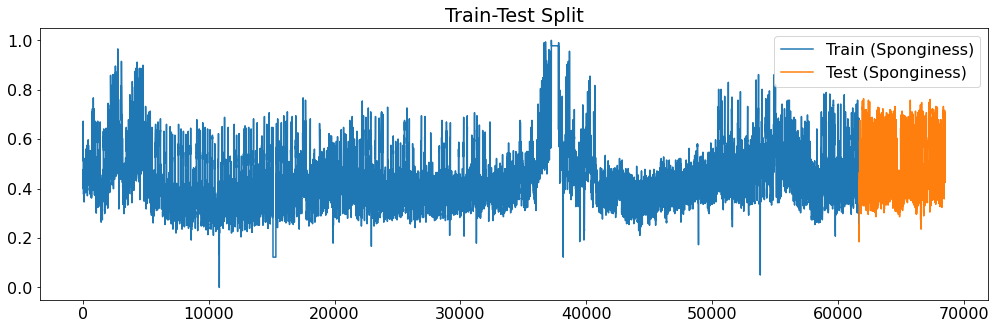

In [7]:
# The test set is 10% the training set
test_size = math.floor(len(dataset) * 0.1)
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Min Max normalization of both sets
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train (Sponginess)')
plt.plot(X_test_raw['Sponginess'], label='Test (Sponginess)')

plt.title('Train-Test Split')
plt.legend()
plt.show()

In [8]:
future = dataset[-window:]
future = (future - X_min) / (X_max - X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [9]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting

In [10]:
X_train , y_train = build_sequences(X_train_raw, column_names, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, column_names, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6156, 200, 7), (6156, 48, 7), (676, 200, 7), (676, 48, 7))

In [11]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if idx == None:
        idx = np.random.randint(0, len(X))
    
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

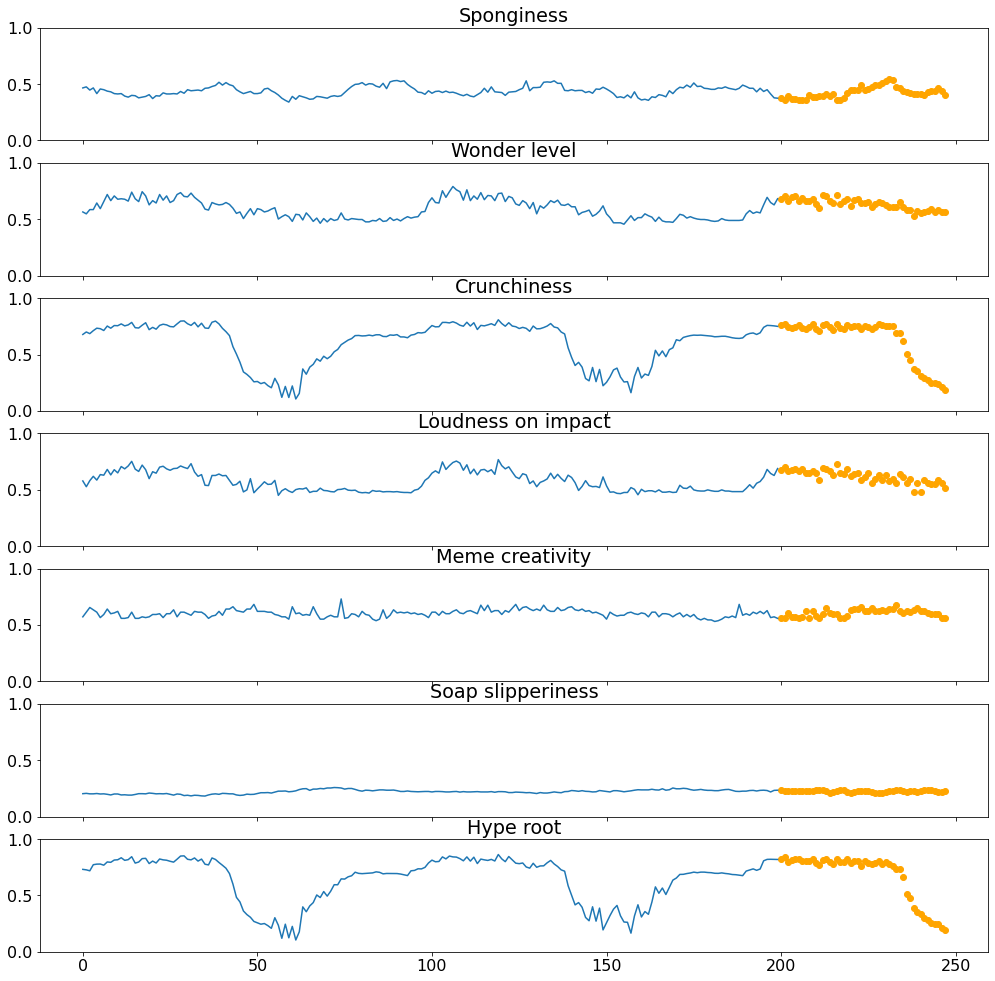

In [12]:
inspect_multivariate(X_train, y_train, column_names, telescope)

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
input_shape, output_shape

((200, 7), (48, 7))

In [14]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Create the sequential model
    model = tf.keras.Sequential()

    # Input layer definition
    model.add(tfkl.Input(shape=input_shape, name='Input'))

    # Bidiractional LSTM layer
    model.add(tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True)))
    
    # 1D Convolutional Layer
    model.add(tfkl.Conv1D(128, 3, padding='same', activation='relu'))
    
    # Max Pooling Layer
    model.add(tfkl.MaxPool1D())
    
    # Bidiractional LSTM layer
    model.add(tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True)))
    
    # 1D Convolutional Layer
    model.add(tfkl.Conv1D(256, 3, padding='same', activation='relu'))
    
    # Max Pooling Layer
    model.add(tfkl.GlobalAveragePooling1D())
    
    # Dropout Layer
    model.add(tfkl.Dropout(.5))
    
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    model.add(tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu'))
    model.add(tfkl.Reshape((output_shape[-2],output_shape[-1])))
    model.add(tfkl.Conv1D(output_shape[-1], 1, padding='same'))

    # Loss function
    loss = tfk.losses.MeanSquaredError()

    # Optimization technique
    #alpha = 1e-4
    optimizer = tfk.optimizers.Adam()#learning_rate=alpha)

    # Validation metrics
    metrics = ['mae']

    #Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [15]:
def build_CONV_LSTM_model_v2(input_shape, output_shape):
    # Auxiliary parameters
    num_layers = 3
    
    # Create the sequential model
    model = tf.keras.Sequential()

    # Input layer definition
    model.add(tfkl.Input(shape=input_shape, name='Input'))

    # Bidirectional LSTM layer
    model.add(tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=False)))
    
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    model.add(tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu'))
    model.add(tfkl.Reshape((output_shape[-2],output_shape[-1])))
    model.add(tfkl.Conv1D(output_shape[-1], 1, padding='same'))

    # Loss function
    loss = tfk.losses.MeanSquaredError()

    # Optimization technique
    #alpha = 1e-4
    optimizer = tfk.optimizers.Adam()#learning_rate=alpha)

    # Validation metrics
    metrics = ['mae']

    #Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [16]:
# Utility function to create callbacks
def create_callbacks():
    callbacks = []

    # Early callback
    callbacks.append(tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True))
    callbacks.append(tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=15, factor=0.5, min_lr=1e-5))
    return callbacks

callbacks = create_callbacks()

#### Predict the test set

In [17]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if idx == None:
        idx = np.random.randint(0, len(X))
    
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

#### Multivariate Forecasting (Autoregression)

In [18]:
X_train, y_train = build_sequences(X_train_raw, column_names, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, column_names, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6156, 200, 7), (6156, 48, 7), (676, 200, 7), (676, 48, 7))

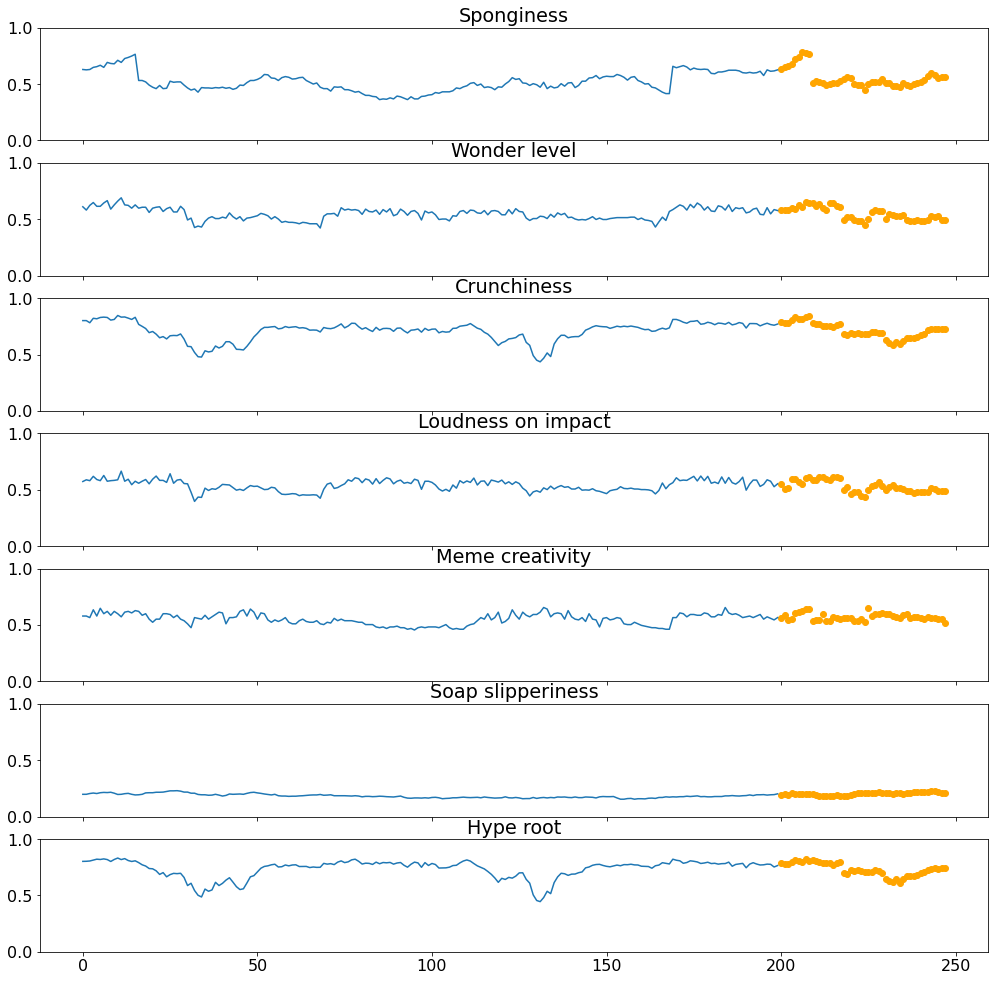

In [19]:
inspect_multivariate(X_train, y_train, column_names, telescope)

2021-12-23 18:17:57.365833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:17:57.487923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:17:57.489065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 18:17:57.490920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 128)          36864     
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

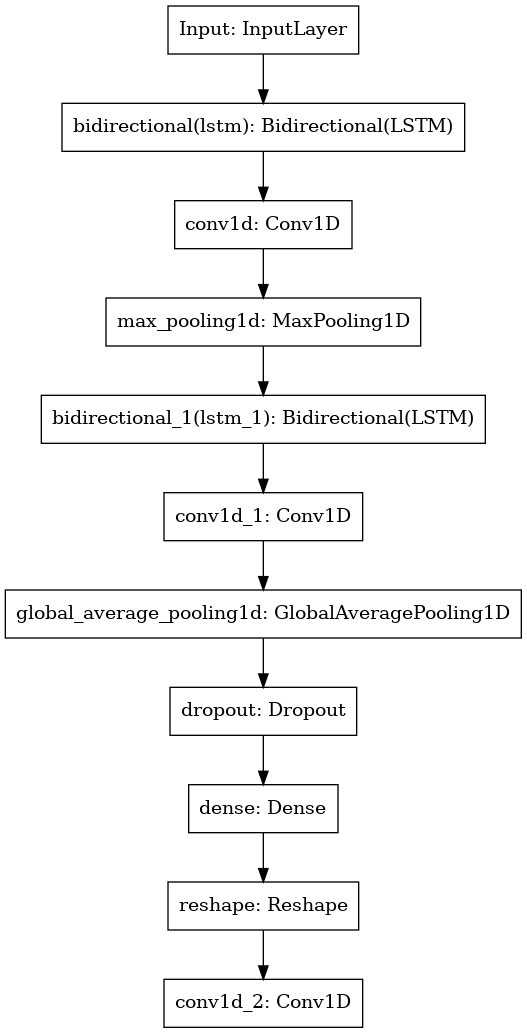

In [20]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [21]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

2021-12-23 18:18:02.522142: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-12-23 18:18:10.303972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


87/87 [==============================] - 19s 58ms/step - loss: 0.2067 - mae: 0.3646 - val_loss: 0.1472 - val_mae: 0.2732
Epoch 2/200
87/87 [==============================] - 3s 40ms/step - loss: 0.0777 - mae: 0.2051 - val_loss: 0.0253 - val_mae: 0.1282
Epoch 3/200
87/87 [==============================] - 4s 42ms/step - loss: 0.0189 - mae: 0.1063 - val_loss: 0.0195 - val_mae: 0.1032
Epoch 4/200
87/87 [==============================] - 3s 40ms/step - loss: 0.0167 - mae: 0.0995 - val_loss: 0.0187 - val_mae: 0.0991
Epoch 5/200
87/87 [==============================] - 4s 40ms/step - loss: 0.0160 - mae: 0.0969 - val_loss: 0.0182 - val_mae: 0.0979
Epoch 6/200
87/87 [==============================] - 4s 42ms/step - loss: 0.0154 - mae: 0.0950 - val_loss: 0.0180 - val_mae: 0.0969
Epoch 7/200
87/87 [==============================] - 4s 43ms/step - loss: 0.0147 - mae: 0.0928 - val_loss: 0.0171 - val_mae: 0.0947
Epoch 8/200
87/87 [==============================] - 3s 40ms/step - loss: 0.0136 - mae:

In [22]:
model.save("Autoreg_48")
#model = tfk.models.load_model('Bi_autoreg_48')

2021-12-23 18:23:35.188302: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


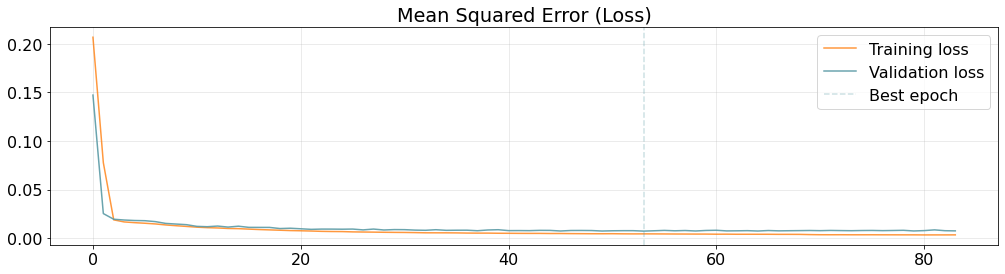

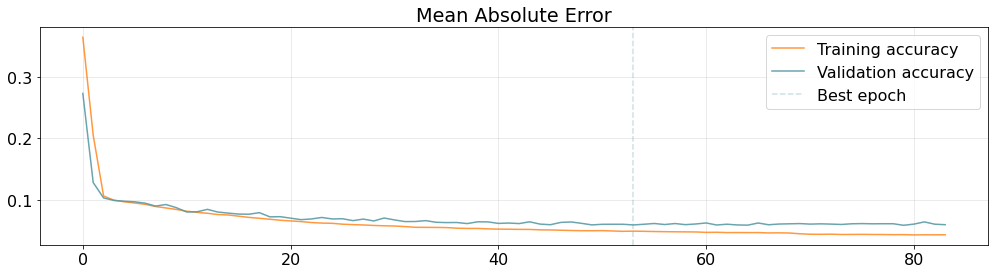

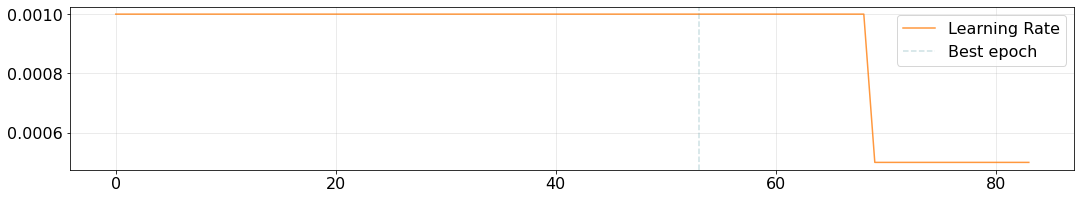

In [23]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, column_names, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [25]:
# Autoregressive Forecasting
out = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(out)==0):
        out = pred_temp
    else:
        out = np.concatenate((out,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [26]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),out.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),out.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.014331905>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08994667>)

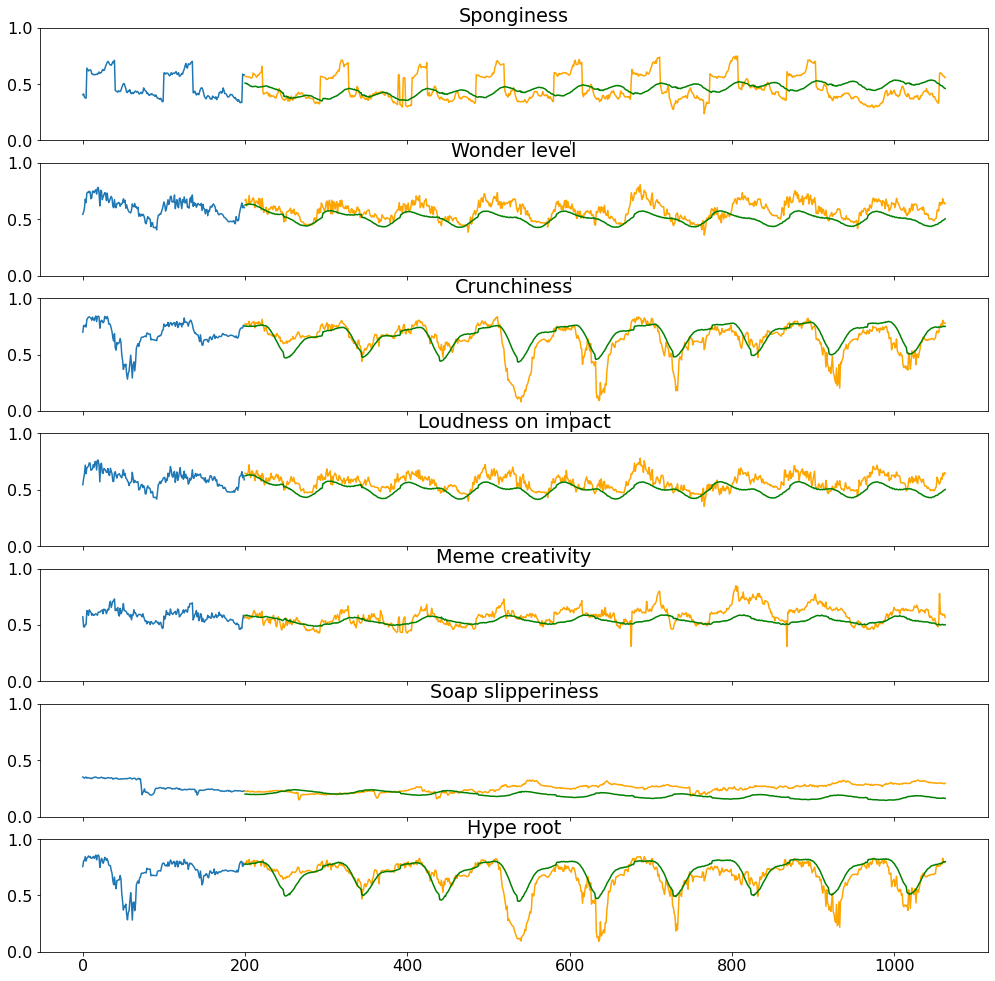

In [27]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, out, column_names, reg_telescope)

In [28]:
out = np.array([])
X_temp = future
for reg in range(0,reg_telescope,telescope):
    #Predict next telescope samples
    pred_temp = model.predict(X_temp)
    if(len(out)==0):
        out = pred_temp
    else:
        #Concatenate predicted samples to the dataset
        out = np.concatenate((out,pred_temp),axis=1)
    #Slide the window for next prediction
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)


In [29]:
maes = []
for i in range(out.shape[1]):
    ft_maes = []
    for j in range(out.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-out[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [30]:
out.shape

(1, 864, 7)

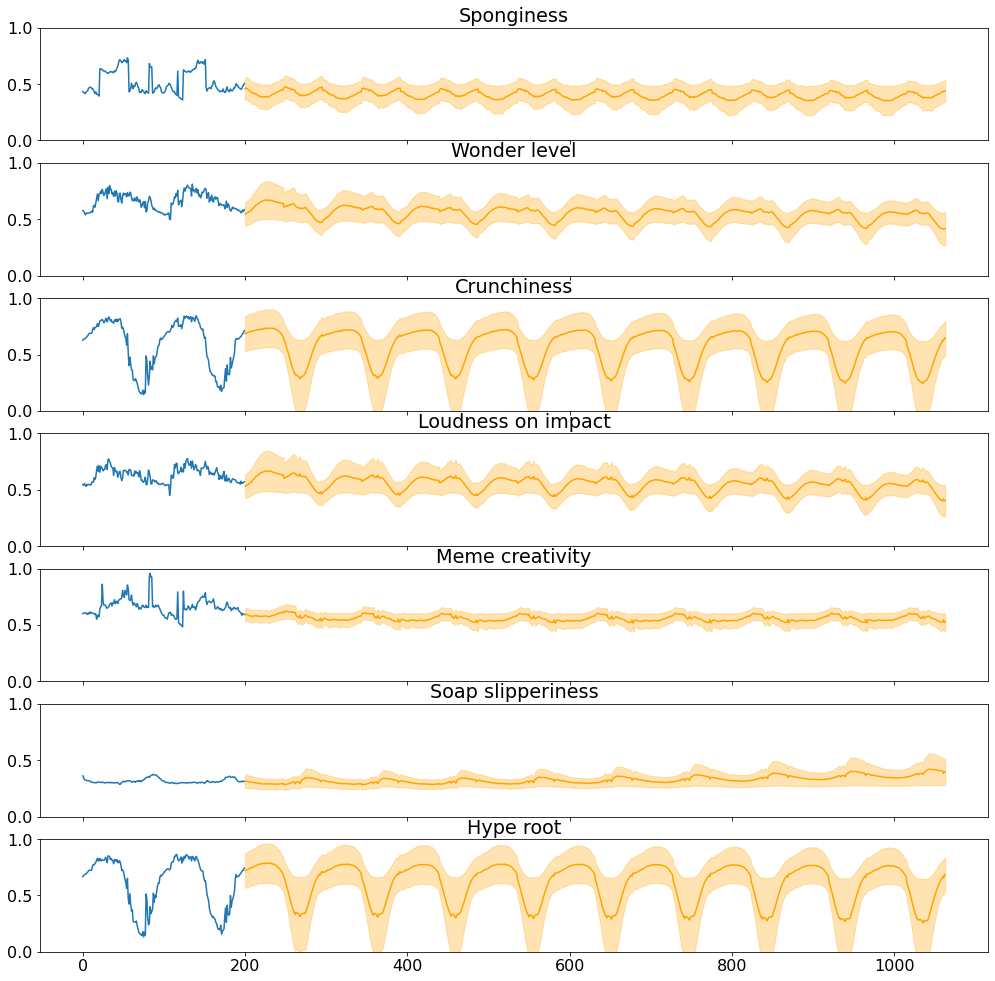

In [31]:
figs, axs = plt.subplots(len(column_names), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(column_names):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), out[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        out[0,:,i]+maes[:,i], 
        out[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

#### Cross Validation

In [ ]:
from sklearn.model_selection import KFold

num_folds = 10

histories = []
scores = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    model = build_dropout_model(input_shape)

    history = model.fit(
        x = X_train.iloc[train_idx],
        y = y_train.iloc[train_idx],
        validation_data=(X_train.iloc[valid_idx], y_train.iloc[valid_idx]),
        batch_size = batch_size,
        epochs = epochs,
        callbacks=callbacks
    ).history
    
    score = model.evaluate(X_train.iloc[valid_idx], y_train.iloc[valid_idx])
    scores.append(score[1])

    histories.append(history)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("MSE")
print("Mean: {}; STD: {}".format(np.mean(scores).round(4), np.std(scores).round(4)))

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds):
    plt.plot(histories[fold_idx]['val_mse'], color=colors[fold_idx], label='Fold N°{}'.format(fold_idx+1))
    plt.ylim(0.011, 0.03)
    plt.title('Mean Squared Error')
    plt.legend(loc='upper right')
    plt.grid(alpha=.3)
plt.show()